# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoProcessor, CLIPModel

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cosine_similarity
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import torch
from transformers import get_linear_schedule_with_warmup

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.5 MB/s eta 0:00:00


In [ ]:
from PIL import Image, ImageOps, UnidentifiedImageError
from pillow_heif import register_heif_opener
register_heif_opener()

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
import random
from typing import List, Optional, Tuple, Dict, Any, Union, Callable

In [ ]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_theme()

Set random seed values for reproducibility

In [ ]:
seed_val = 6   # 42, 17, 6

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
mount = ''
model_dir = f'{mount}/code/CLIP/models'
pred_dir = f'{mount}/code/CLIP/predictions'

# Data

## Read data and split randomly

In [ ]:
station_names = ['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

In [ ]:
data_dir = f'{mount}/data'

In [ ]:
os.listdir(data_dir)

['Anna', 'Beate', 'Berkay']

In [ ]:
df = []
file_types = ['raw']  # raw, processed
st_name_vis_options = ['st_name', 'no_st_name']  # station name visibility

for author in os.listdir(data_dir):
  for file_type in file_types:
    for station in station_names:
      for st_name_vis in st_name_vis_options:
        for f in os.listdir(f'{data_dir}/{author}/{file_type}/{station}/{st_name_vis}'):
          df.append((station, author, file_type, st_name_vis, f,
                     f'{author}/{file_type}/{station}/{st_name_vis}/{f}'))

df = pd.DataFrame(df, columns=['station', 'author', 'file_type',
                               'st_name_visible', 'filename', 'file_path'])

# ensures correct order of appearance in plots
df['station'] = pd.Categorical(df['station'], ordered=True,
                categories=['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University'])

df['st_name_visible'] = df['st_name_visible'].replace({'st_name': True, 'no_st_name': False})
df['st_name_visible'] = pd.Categorical(df['st_name_visible'], ordered=True, categories=[True, False])

df.head()

/tmp/ipython-input-52-3881505212.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['st_name_visible'] = df['st_name_visible'].replace({'st_name': True, 'no_st_name': False})


,station,author,file_type,st_name_visible,filename,file_path
0,Stadtmitte,Anna,raw,True,20250513_132112.jpg,Anna/raw/Stadtmitte/st_name/20250513_132112.jpg
1,Stadtmitte,Anna,raw,True,20250512_132302.jpg,Anna/raw/Stadtmitte/st_name/20250512_132302.jpg
2,Stadtmitte,Anna,raw,True,20250512_132259.jpg,Anna/raw/Stadtmitte/st_name/20250512_132259.jpg
3,Stadtmitte,Anna,raw,True,20250512_132258.jpg,Anna/raw/Stadtmitte/st_name/20250512_132258.jpg
4,Stadtmitte,Anna,raw,True,20250512_132243.jpg,Anna/raw/Stadtmitte/st_name/20250512_132243.jpg


In [ ]:
df.shape

(182, 6)

Keep correctly labeled images

In [ ]:
df = df[df['station'].isin(station_names)]
df.shape

(182, 6)

Filter data

In [ ]:
# drop Hauptbahnhof
station_names = ['Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']
df = df[df['station'] != 'Hauptbahnhof']
df.shape

(182, 6)

Split randomly into train / val / test set

In [ ]:
# train / val / test -- 0.7 / 0.1 / 0.2
test_size, val_size = round(df.shape[0] * 0.2), round(df.shape[0] * 0.1)

In [ ]:
df_train, df_test = train_test_split(df, test_size=test_size)
df_train, df_val = train_test_split(df_train, test_size=val_size)

(7, 1, 2)

## Read dataset (hard split)

In [ ]:
ds_version = 5  # 4 classes w/o Hbf / 5 classes with Hbf

In [ ]:
if ds_version == 4:
  station_names = ['Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']
elif ds_version == 5:
  station_names = ['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

data_dir = f'{mount}/dataset/dataset_{ds_version}'
data_dir

'/content/drive/MyDrive/Uni Stuttgart/AACV/dataset/dataset_5'

In [ ]:
df_train = pd.read_csv(f'{data_dir}/train/df_train.csv')
df_val = pd.read_csv(f'{data_dir}/val/df_val.csv')
df_test = pd.read_csv(f'{data_dir}/test/df_test.csv')

df_test_st_name = pd.read_csv(
    f'{data_dir}/test_st_name/st_name_visible/df_test_st_name_visible.csv')
df_test_mask = pd.read_csv(
    f'{data_dir}/test_st_name/st_name_masked/df_test_st_name_masked.csv')

print('Train:', df_train.shape[0])
print('Val:', df_val.shape[0])
print('Test:', df_test.shape[0])
print('Test st. name visible:', df_test_st_name.shape[0])
print('Test st. name masked:', df_test_mask.shape[0])

Train: 151
Val: 22
Test: 43
Test st. name visible: 25
Test st. name masked: 25


In [ ]:
df_train.head()

,station,author,file_type,st_name_visible,filename,file_path
0,University,Anna,raw,True,uni_name_5.png,train/images/uni_name_5.png
1,Schwabstrasse,Beate,raw,False,20250502_142758.jpg,train/images/20250502_142758.jpg
2,Feuersee,Anna,raw,False,f_no_name_3.png,train/images/f_no_name_3.png
3,Stadtmitte,Anna,raw,False,20250506_111040.jpg,train/images/20250506_111040.jpg
4,Stadtmitte,Anna,raw,True,20250512_132259.jpg,train/images/20250512_132259.jpg


## Dataset class

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, data_dir, df, transform=None, prompt=None):
        self.data_dir = data_dir
        self.df = df
        self.transform = transform
        self.prompt = prompt

        #TODO: trial read through of all images

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, ind):
        item_metadata = self.df.iloc[ind].to_dict()
        text = item_metadata['station']
        if self.prompt:
          text = self.prompt.format(text)

        image_filepath = f"{self.data_dir}/{item_metadata['file_path']}"
        image = Image.open(image_filepath)
        if self.transform:
          image = self.transform(image)
        # print(image)
        return image, text

# Zero-shot

Load model

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16", attn_implementation="eager")
model.to(device);
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

Prepare data

Tried prompts:
* bare station names
* A photo of the S-Bahn station "Stuttgart {}". [BEST]
* A photo of the S-Bahn station "Stuttgart {}" taken through the carriage window.
* A photo of the S-Bahn station "Stuttgart {}" taken from the train.

In [ ]:
prompt = 'A photo of the S-Bahn station "Stuttgart {}".'
station_text = [prompt.format(st) for st in station_names]

In [ ]:
batch_size = 16

test_dataset = ImageDataset(data_dir=data_dir, df=df_test,
                            transform=processor.image_processor, prompt=prompt)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Run zero-shot classification (match image with closest station description in the emb. space)

In [ ]:
def do_test(batch):
  batch_img = batch[0].to(device)['pixel_values'][0].to(device)
  batch_labels = batch[1]
  inputs = processor(text=batch_labels, return_tensors="pt", padding=True).to(device)
  inputs['pixel_values'] = batch_img

  with torch.no_grad():
    inputs = processor(text=station_text, return_tensors="pt", padding=True).to(device)
    inputs['pixel_values'] = batch_img
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    station_probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    pred = [station_names[i] for i in np.argmax(station_probs, axis=1)]

  del inputs, batch_img, batch_labels, logits_per_image

  return pred

In [ ]:
test_pred = []

for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    batch_pred = do_test(batch)
    test_pred.extend(batch_pred)
    del batch

df_test['predictions'] = test_pred

100%|██████████| 3/3 [00:22<00:00,  7.36s/it]


Calculate metrics

In [ ]:
acc = accuracy_score(df_test['station'], df_test['predictions'])
f1 = f1_score(df_test['station'], df_test['predictions'], average='macro')

print(f"Test accuracy: {acc:.3f}")
print(f"Test F1 macro: {f1:.3f}")

Test accuracy: 0.419
Test F1 macro: 0.429


Save predictions

In [ ]:
pred_dir = f'/content/drive/MyDrive/Uni Stuttgart/AACV/code/CLIP/predictions'

df_test['predictions'].to_csv(f'{pred_dir}/test_clip_0shot_cl{len(station_names)}.csv', index=False)

# Fine-tuning

## Fine-tuning [OpenAI CLIP]

Install CLIP

In [ ]:
%%capture
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
import clip  # official version
# import clip_attention  # code modified to return attention weights

Init model from pretrained

In [ ]:
model, preprocess = clip_attention.load('ViT-B/16', device=device, jit=False)
model.float();

Or load a fine-tuned model from disk

In [ ]:
model, preprocess = clip_attention.load('ViT-B/16', device=device, jit=False)
model.float();

model_dir = f'{mount}/code/CLIP/models'
checkpoint = torch.load(f'{model_dir}/clip_ft_cl4_ep1_lr1e-05.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Train-test split

In [ ]:
df = df.head(10)  # for sanity checks

In [ ]:
batch_size = 32 if device == 'cuda' else 16

# train / val / test -- 0.7 / 0.1 / 0.2
test_size, val_size = round(df.shape[0] * 0.2), round(df.shape[0] * 0.1)

In [ ]:
df_train, df_test = train_test_split(df, test_size=test_size)
df_train, df_val = train_test_split(df_train, test_size=val_size)

train_dataset = ImageDataset(data_dir=data_dir, df=df_train, transform=preprocess)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = ImageDataset(data_dir=data_dir, df=df_test, transform=preprocess)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = ImageDataset(data_dir=data_dir, df=df_val, transform=preprocess)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

len(train_dataset), len(val_dataset), len(test_dataset)

(7, 1, 2)

Define loss

In [ ]:
loss_img = CrossEntropyLoss()
loss_txt = CrossEntropyLoss()

Tokenize text (before training starts for efficiency)

In [ ]:
station_text = [
    f'A photo of the S-Bahn station "Stuttgart {st}".'
    for st in station_names]
station_tokens = {station_names[i]: clip.tokenize(station_text)[i] for i in range(len(station_names))}

Train function

In [ ]:
def do_train(batch):
  optimizer.zero_grad()
  batch_img, batch_labels = batch[0].to(device), batch[1]
  batch_txt = torch.stack([station_tokens[st] for st in batch_labels], dim=0).to(device)

  # forward pass
  logits_per_image, logits_per_text = model(batch_img, batch_txt)

  # compute loss
  ground_truth = torch.arange(len(batch_img), dtype=torch.long, device=device)
  total_loss = (
      loss_img(logits_per_image, ground_truth) + \
      loss_txt(logits_per_text, ground_truth)) / 2

  # backward pass
  total_loss.backward()
  optimizer.step()
  scheduler.step()

  del batch_img, batch_labels, batch_txt, logits_per_image, logits_per_text, ground_truth

  return total_loss.item()

Test function

In [ ]:
def do_test(batch):
  batch_img, batch_labels = batch[0].to(device), batch[1]
  batch_txt = torch.stack([station_tokens[st] for st in batch_labels], dim=0).to(device)

  with torch.no_grad():
    # compute loss
    logits_per_image, logits_per_text = model(batch_img, batch_txt)
    ground_truth = torch.arange(len(batch_img), dtype=torch.long, device=device)
    total_loss = (
      loss_img(logits_per_image, ground_truth) + \
      loss_txt(logits_per_text, ground_truth)) / 2
    # print(logits_per_image, ground_truth)

    # get predictions
    batch_txt = torch.stack(list(station_tokens.values()), dim=0).to(device)
    logits_per_image, logits_per_text = model(batch_img, batch_txt)
    station_probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    pred = [station_names[i] for i in np.argmax(station_probs, axis=1)]

  del batch_img, batch_labels, batch_txt, logits_per_image, logits_per_text, ground_truth

  return total_loss.item(), pred

Set hyperparameters

In [ ]:
num_epochs = 1  # 8
lr = 1e-5

optimizer = AdamW(
    model.parameters(),
    lr=lr,
    # weight_decay=0.01
    )

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training loop

In [ ]:
train_loss_arr, val_loss_arr, val_acc_arr = [], [], []

for epoch in range(num_epochs):
    # train
    train_loss = 0.0
    for batch in tqdm(train_dataloader, total=len(train_dataloader)):
        batch_loss = do_train(batch)
        train_loss += batch_loss
        del batch
    train_loss /= len(train_dataset)
    print(f"Epoch {epoch}: Train loss: {train_loss:.4f}")
    train_loss_arr.append(train_loss)

    # val
    val_pred = []
    val_loss = 0.0
    for batch in tqdm(val_dataloader, total=len(val_dataloader)):
        batch_loss, batch_pred = do_test(batch)
        val_pred.extend(batch_pred)
        val_loss += batch_loss
        del batch

    val_acc = accuracy_score(df_val['station'], val_pred)
    val_loss /= len(val_dataset)
    print(f"Val loss: {val_loss:.4f}, Acc: {val_acc:.3f}")
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)

    print()

Loss plot

In [ ]:
train_stats = pd.DataFrame()
train_stats['epoch'] = list(range(num_epochs)) + list(range(num_epochs))
train_stats['loss_type'] = ['train'] * num_epochs + ['val'] * num_epochs
train_stats['loss_value'] = train_loss_arr + val_loss_arr
train_stats

,epoch,loss_type,loss_value
0,0,train,0.119358
1,1,train,0.095965
2,2,train,0.088276
3,3,train,0.081508
4,4,train,0.075914
5,5,train,0.072209
6,6,train,0.069992
7,7,train,0.069035
8,0,val,0.135677
9,1,val,0.123484


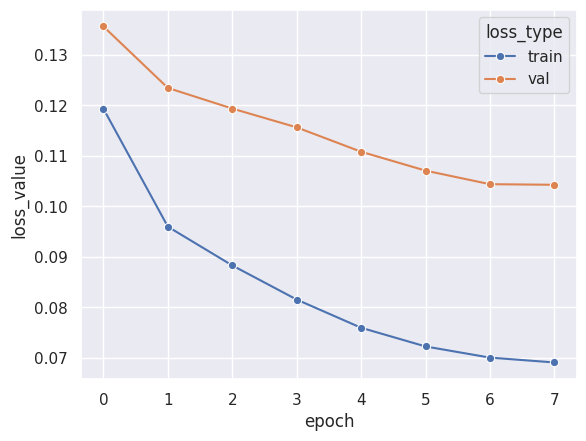

In [ ]:
sns.lineplot(train_stats, x='epoch', y='loss_value', hue='loss_type', marker='o');

Testing

In [ ]:
test_pred = []
test_loss = 0.0

for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    batch_loss, batch_pred = do_test(batch)
    test_pred.extend(batch_pred)
    test_loss += batch_loss
    del batch

df_test['predictions'] = test_pred

test_loss /= len(test_dataset)

print(f"Test loss: {test_loss:3f}")
print(f"Test accuracy: {accuracy_score(df_test['station'], df_test['predictions']):.3f}")

100%|██████████| 1/1 [00:09<00:00,  9.21s/it]

Test loss: 0.375268
Test accuracy: 0.000


In [ ]:
df_test[['station', 'predictions']]

,station,predictions
118,Schwabstrasse,Schwabstrasse
72,Stadtmitte,Stadtmitte
81,Feuersee,Feuersee
60,Stadtmitte,Stadtmitte
176,Schwabstrasse,Schwabstrasse
121,Schwabstrasse,Schwabstrasse
136,University,University
15,Stadtmitte,Stadtmitte
144,University,University
141,University,University


In [ ]:
model_dir = f'{mount}/code/CLIP/models'

torch.save({
        'model_state_dict': model.state_dict(),
        }, f"{model_dir}/clip_ft_cl{len(station_names)}_ep{num_epochs}_lr{lr}.pt")

## Fine-tuning [HuggingFace]

Load model

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16", attn_implementation="eager")
# model = CLIPModel.from_pretrained(
#     f'{model_dir}/clip_ft42_cl5_bs16_ep8_lr1e-05',
#     attn_implementation="eager")

model.to(device);

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
station_names

['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

Prepare data

In [ ]:
prompt = 'A photo of the S-Bahn station "Stuttgart {}".'

# for inference
station_text = [prompt.format(st) for st in station_names]
station_text

['A photo of the S-Bahn station "Stuttgart Hauptbahnhof".',
 'A photo of the S-Bahn station "Stuttgart Stadtmitte".',
 'A photo of the S-Bahn station "Stuttgart Feuersee".',
 'A photo of the S-Bahn station "Stuttgart Schwabstrasse".',
 'A photo of the S-Bahn station "Stuttgart University".']

In [ ]:
# df_train = df_train.head(10)  # for sanity checks
# df_val = df_val.head(10)  # for sanity checks
# df_test = df_test.head(10)  # for sanity checks

In [ ]:
batch_size = 16 if device == 'cuda' else 16

In [ ]:
train_dataset = ImageDataset(data_dir=data_dir, df=df_train,
                             transform=processor.image_processor, prompt=prompt)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = ImageDataset(data_dir=data_dir, df=df_val,
                           transform=processor.image_processor, prompt=prompt)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = ImageDataset(data_dir=data_dir, df=df_test,
                            transform=processor.image_processor, prompt=prompt)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

len(train_dataset), len(val_dataset), len(test_dataset)

(151, 22, 43)

Define loss

In [ ]:
loss_img = CrossEntropyLoss()
loss_txt = CrossEntropyLoss()

Train function

In [ ]:
def do_train(batch):
  optimizer.zero_grad()

  #TODO: put this into custom dataloader
  batch_img = batch[0].to(device)['pixel_values'][0].to(device)
  batch_labels = batch[1]
  inputs = processor(text=batch_labels, return_tensors="pt", padding=True).to(device)
  inputs['pixel_values'] = batch_img

  # forward pass
  outputs = model(**inputs)
  logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

  # compute loss
  ground_truth = torch.arange(len(batch_img), dtype=torch.long, device=device)
  total_loss = (
      loss_img(logits_per_image, ground_truth) + \
      loss_txt(logits_per_text, ground_truth)) / 2

  # backward pass
  total_loss.backward()
  optimizer.step()
  scheduler.step()

  del inputs, batch_img, batch_labels, logits_per_image, logits_per_text, ground_truth

  return total_loss.item()

Test function

In [ ]:
def do_test(batch):
  batch_img = batch[0].to(device)['pixel_values'][0].to(device)
  batch_labels = batch[1]
  inputs = processor(text=batch_labels, return_tensors="pt", padding=True).to(device)
  inputs['pixel_values'] = batch_img

  with torch.no_grad():
    # compute loss
    outputs = model(**inputs)
    logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text
    ground_truth = torch.arange(len(batch_img), dtype=torch.long, device=device)
    total_loss = (
      loss_img(logits_per_image, ground_truth) + \
      loss_txt(logits_per_text, ground_truth)) / 2

    # get predictions
    inputs = processor(text=station_text, return_tensors="pt", padding=True).to(device)
    inputs['pixel_values'] = batch_img
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    station_probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    pred = [station_names[i] for i in np.argmax(station_probs, axis=1)]

  del inputs, batch_img, batch_labels, logits_per_image, logits_per_text, ground_truth

  return total_loss.item(), pred

Set hyperparameters

In [ ]:
num_epochs = 8
# early_stop = 3
lr = 1e-5

optimizer = AdamW(
    model.parameters(),
    lr=lr,
    # weight_decay=0.01
    )

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training loop

In [ ]:
train_loss_arr, val_loss_arr, val_acc_arr = [], [], []

for epoch in range(num_epochs):
    # train
    train_loss = 0.0
    for batch in tqdm(train_dataloader, total=len(train_dataloader)):
        batch_loss = do_train(batch)
        train_loss += batch_loss
        del batch
    train_loss /= len(train_dataset)
    print(f"Epoch {epoch}: Train loss: {train_loss:.4f}")
    train_loss_arr.append(train_loss)

    # val
    val_pred = []
    val_loss = 0.0
    for batch in tqdm(val_dataloader, total=len(val_dataloader)):
        batch_loss, batch_pred = do_test(batch)
        val_pred.extend(batch_pred)
        val_loss += batch_loss
        del batch

    val_acc = accuracy_score(df_val['station'], val_pred)
    val_f1 = f1_score(df_val['station'], val_pred, average='macro')
    val_loss /= len(val_dataset)
    print(f"Val loss: {val_loss:.4f}, Acc: {val_acc:.3f}, F1: {val_f1:.3f}")
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)

    # early stopping
    # if epoch == early_stop:
      # break

    print()

100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


Epoch 0: Train loss: 0.1754


100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


Val loss: 0.1458, Acc: 0.591, F1: 0.558



100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


Epoch 1: Train loss: 0.1243


100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


Val loss: 0.1314, Acc: 0.591, F1: 0.584



100%|██████████| 10/10 [00:52<00:00,  5.25s/it]


Epoch 2: Train loss: 0.1066


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Val loss: 0.1076, Acc: 0.682, F1: 0.685



100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


Epoch 3: Train loss: 0.0928


100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


Val loss: 0.0898, Acc: 1.000, F1: 1.000



100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


Epoch 4: Train loss: 0.0870


100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


Val loss: 0.0909, Acc: 0.909, F1: 0.900



100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


Epoch 5: Train loss: 0.0851


100%|██████████| 2/2 [00:05<00:00,  2.82s/it]


Val loss: 0.0886, Acc: 0.909, F1: 0.900



100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


Epoch 6: Train loss: 0.0842


100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


Val loss: 0.0877, Acc: 0.955, F1: 0.949



100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Epoch 7: Train loss: 0.0840


100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

Val loss: 0.0879, Acc: 0.955, F1: 0.949



Loss plot

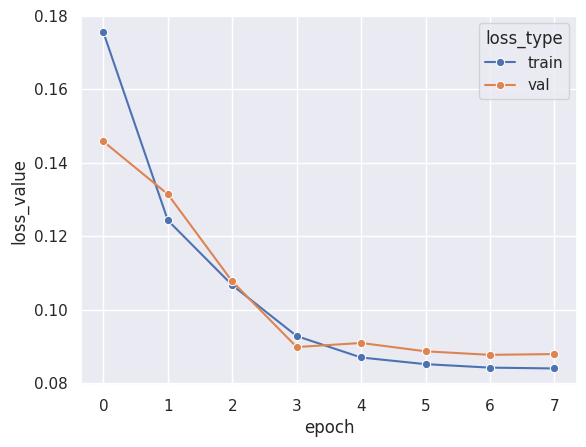

In [ ]:
num_epochs = len(train_loss_arr)  # accounts for early stopping
train_stats = pd.DataFrame()
train_stats['epoch'] = list(range(num_epochs)) + list(range(num_epochs))
train_stats['loss_type'] = ['train'] * num_epochs + ['val'] * num_epochs
train_stats['loss_value'] = train_loss_arr + val_loss_arr

sns.lineplot(train_stats, x='epoch', y='loss_value', hue='loss_type', marker='o');

Testing

In [ ]:
test_pred = []
test_loss = 0.0

for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    batch_loss, batch_pred = do_test(batch)
    test_pred.extend(batch_pred)
    test_loss += batch_loss
    del batch

df_test['predictions'] = test_pred

test_loss /= len(test_dataset)

print(f"Test loss: {test_loss:3f}")

100%|██████████| 3/3 [00:14<00:00,  4.74s/it]

Test loss: 0.095820


Calculate metrics

In [ ]:
acc = accuracy_score(df_test['station'], df_test['predictions'])
f1 = f1_score(df_test['station'], df_test['predictions'], average='macro')

print(f"Test accuracy: {acc:.3f}")
print(f"Test F1 macro: {f1:.3f}")

Test accuracy: 1.000
Test F1 macro: 1.000


Save predictions

In [ ]:
df_test['predictions'].to_csv(
  f'{pred_dir}/test_clip_ft{seed_val}_cl{len(station_names)}_bs{batch_size}_ep{num_epochs}_lr{lr}.csv',
  index=False)

Save model

In [ ]:
model.save_pretrained(
    f"{model_dir}/clip_ft{seed_val}_cl{len(station_names)}_bs{batch_size}_ep{num_epochs}_lr{lr}")

# Test: st. name visible vs masked

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16", attn_implementation="eager")
# model = CLIPModel.from_pretrained(
#     f'{model_dir}/clip_ft_cl4_bs16_ep8_lr1e-05',
#     attn_implementation="eager")

model.to(device);

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
def do_test(batch):
  batch_img = batch[0].to(device)['pixel_values'][0].to(device)
  batch_labels = batch[1]
  inputs = processor(text=batch_labels, return_tensors="pt", padding=True).to(device)
  inputs['pixel_values'] = batch_img

  with torch.no_grad():
    # get predictions
    inputs = processor(text=station_text, return_tensors="pt", padding=True).to(device)
    inputs['pixel_values'] = batch_img
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    station_probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    pred = [station_names[i] for i in np.argmax(station_probs, axis=1)]

  del inputs, batch_img, batch_labels, logits_per_image

  return pred

Prepare data

In [ ]:
prompt = 'A photo of the S-Bahn station "Stuttgart {}".'

# for inference
station_text = [prompt.format(st) for st in station_names]
station_text

['A photo of the S-Bahn station "Stuttgart Hauptbahnhof".',
 'A photo of the S-Bahn station "Stuttgart Stadtmitte".',
 'A photo of the S-Bahn station "Stuttgart Feuersee".',
 'A photo of the S-Bahn station "Stuttgart Schwabstrasse".',
 'A photo of the S-Bahn station "Stuttgart University".']

In [ ]:
batch_size = 16 if device == 'cuda' else 16

In [ ]:
test_st_name_dataset = ImageDataset(data_dir=data_dir,
                                    df=df_test_st_name,
                                    transform=processor.image_processor,
                                    prompt=prompt)
test_st_name_dataloader = DataLoader(test_st_name_dataset, batch_size=batch_size)

test_mask_dataset = ImageDataset(data_dir=data_dir,
                                    df=df_test_mask,
                                    transform=processor.image_processor,
                                    prompt=prompt)
test_mask_dataloader = DataLoader(test_mask_dataset, batch_size=batch_size)

len(test_st_name_dataset), len(test_mask_dataset)

(25, 25)

Testing

In [ ]:
test_pred = []

for batch in tqdm(test_st_name_dataloader, total=len(test_st_name_dataloader)):
    batch_pred = do_test(batch)
    test_pred.extend(batch_pred)
    del batch

df_test_st_name['predictions'] = test_pred

acc = accuracy_score(df_test_st_name['station'], df_test_st_name['predictions'])
f1 = f1_score(df_test_st_name['station'], df_test_st_name['predictions'], average='macro')

print('Station name visible:')
print(f"Test accuracy: {acc:.3f}")
print(f"Test F1 macro: {f1:.3f}")
print()

#=================

test_pred = []

for batch in tqdm(test_mask_dataloader, total=len(test_mask_dataloader)):
    batch_pred = do_test(batch)
    test_pred.extend(batch_pred)
    del batch

df_test_mask['predictions'] = test_pred

acc = accuracy_score(df_test_mask['station'], df_test_mask['predictions'])
f1 = f1_score(df_test_mask['station'], df_test_mask['predictions'], average='macro')

print('Station name masked:')
print(f"Test accuracy: {acc:.3f}")
print(f"Test F1 macro: {f1:.3f}")

100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Station name visible:
Test accuracy: 1.000
Test F1 macro: 1.000



100%|██████████| 2/2 [00:07<00:00,  3.54s/it]

Station name masked:
Test accuracy: 1.000
Test F1 macro: 1.000


Directly compare predictions

In [ ]:
df_joint = df_test_st_name[[
    'station', 'author', 'file_type', 'filename', 'predictions']].rename(columns={
    'predictions': 'st_name_pred'}).merge(
        df_test_mask[['filename', 'predictions']].rename(columns={'predictions': 'mask_pred'}),
        on='filename')
df_joint

,station,author,file_type,filename,st_name_pred,mask_pred
0,University,Beate,raw,20250519_130403.jpg,University,University
1,University,Beate,raw,20250502_130133.jpg,University,University
2,Schwabstrasse,Beate,raw,20250417_111132.jpg,Hauptbahnhof,Hauptbahnhof
3,Stadtmitte,Anna,raw,20250508_133817.jpg,Stadtmitte,Stadtmitte
4,University,Beate,raw,20250520_132914.jpg,Feuersee,Feuersee
5,Stadtmitte,Beate,raw,20250424_121641.jpg,Stadtmitte,Stadtmitte
6,Stadtmitte,Beate,raw,20250502_113659.jpg,Hauptbahnhof,Hauptbahnhof
7,Feuersee,Anna,raw,f_name_1.png,Stadtmitte,Stadtmitte
8,Schwabstrasse,Anna,raw,schwab_name_3.png,Hauptbahnhof,Hauptbahnhof
9,University,Anna,raw,20250512_130908.jpg,University,University


In [ ]:
df_joint[df_joint['st_name_pred'] != df_joint['mask_pred']]

,station,author,file_type,filename,st_name_pred,mask_pred


Save predictions

In [ ]:
df_test_st_name['predictions'].to_csv(
    f'{pred_dir}/test_st_name_clip_ft{seed_val}_cl4_bs16_ep8_lr1e-05.csv',
    index=False)

df_test_mask['predictions'].to_csv(
    f'{pred_dir}/test_mask_clip_ft{seed_val}_cl4_bs16_ep8_lr1e-05.csv',
    index=False)

# Cross-validation

## Split data for cross-validation
* train: 70%
* val: 10%
* test: 20%

In [ ]:
# for now!
# df = df.head(20)

In [ ]:
n_splits = 5  # test 20%
val_size = round(df.shape[0] * 0.1)  # val 10%

kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed_val)
kf_ind_lookup = dict()

for i, (train_index, test_index) in enumerate(kf.split(df)):
    train_index, val_index = train_test_split(train_index, test_size=val_size)
    kf_ind_lookup[i] = {
        'train': train_index,
        'val': val_index,
        'test': test_index
    }

kf_ind_lookup[0]

{'train': array([ 91,  93,  23,  34,  94, 142,  56,  12,  49, 151,   6, 115, 108,
        146,  79, 143, 105,  51, 110,  62,  67, 150,  63, 127,  36, 159,
         28,  58, 156,   3, 133,  80, 152, 171, 101,  66, 158,  41,  33,
         45, 104,  96, 129, 161,  60,  77, 126, 147,   5, 169, 134,  30,
         20,  27,  65,  73, 121,  87,  59,  22,   4, 160,  44, 155,  46,
        123, 120,  50,  29,  78,  25,  99, 100, 138,  18, 144, 107,  90,
        125, 137, 157,  83,  55, 164, 167, 163, 113,  54,  92, 165,  13,
         95,  21,  82,  84, 141,  52, 172,  40, 130, 111,  15,   8, 128,
         68,  74, 122,   2,  61, 149,  31,  39,  75,  89, 153,  43,   7,
        131,  88, 114,  24]),
 'val': array([ 10,  32,  17, 117, 145,  57,  72,  26, 170,  14,  35,  38,  47,
         85,   1,  53,  98]),
 'test': array([  0,   9,  11,  16,  19,  37,  42,  48,  64,  69,  70,  71,  76,
         81,  86,  97, 102, 103, 106, 109, 112, 116, 118, 119, 124, 132,
        135, 136, 139, 140, 148, 154, 16

## Helper functions

Get dataloaders for given data split

In [ ]:
def get_dataloaders(kf_i):
  df_train = df.iloc[kf_ind_lookup[kf_i]['train']]
  train_dataset = ImageDataset(data_dir=data_dir, df=df_train, transform=preprocess)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

  df_val = df.iloc[kf_ind_lookup[kf_i]['val']]
  val_dataset = ImageDataset(data_dir=data_dir, df=df_val, transform=preprocess)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

  df_test = df.iloc[kf_ind_lookup[kf_i]['test']]
  test_dataset = ImageDataset(data_dir=data_dir, df=df_test, transform=preprocess)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  return df_train, train_dataloader, \
    df_val, val_dataloader, \
    df_test, test_dataloader

Do the whole training loop

In [ ]:
def do_training_loop(df_train, train_dataloader, df_val, val_dataloader):
  train_loss_arr, val_loss_arr, val_acc_arr = [], [], []

  for epoch in range(num_epochs):
      # train
      train_loss = 0.0
      for batch in tqdm(train_dataloader, total=len(train_dataloader)):
          batch_loss = do_train(batch)
          train_loss += batch_loss
          del batch
      train_loss /= df_train.shape[0]
      print(f"Epoch {epoch}: Train loss: {train_loss:.4f}")
      train_loss_arr.append(train_loss)

      # val
      val_pred = []
      val_loss = 0.0
      for batch in tqdm(val_dataloader, total=len(val_dataloader)):
          batch_loss, batch_pred = do_test(batch)
          val_pred.extend(batch_pred)
          val_loss += batch_loss
          del batch

      val_acc = accuracy_score(df_val['station'], val_pred)
      val_loss /= df_val.shape[0]
      print(f"Val loss: {val_loss:.4f}, Acc: {val_acc:.3f}")
      val_loss_arr.append(val_loss)
      val_acc_arr.append(val_acc)

  print()

  return train_loss_arr, val_loss_arr, val_acc_arr

Do the whole testing procedure

In [ ]:
def do_test_loop(df_test, test_dataloader):
  test_pred = []
  test_loss = 0.0

  for batch in tqdm(test_dataloader, total=len(test_dataloader)):
      batch_loss, batch_pred = do_test(batch)
      test_pred.extend(batch_pred)
      test_loss += batch_loss
      del batch

  df_test['predictions'] = test_pred

  test_loss /= df_test.shape[0]
  test_acc = accuracy_score(df_test['station'], df_test['predictions'])

  print(f"Test loss: {test_loss:3f}")
  print(f"Test accuracy: {test_acc:.3f}")

  return test_loss, test_acc

Train on one batch

In [ ]:
def do_train(batch):
  optimizer.zero_grad()
  batch_img, batch_labels = batch[0].to(device), batch[1]
  batch_txt = torch.stack([station_tokens[st] for st in batch_labels], dim=0).to(device)

  # forward pass
  logits_per_image, logits_per_text = model(batch_img, batch_txt)

  # compute loss
  ground_truth = torch.arange(len(batch_img), dtype=torch.long, device=device)
  total_loss = (
      loss_img(logits_per_image, ground_truth) + \
      loss_txt(logits_per_text, ground_truth)) / 2

  # backward pass
  total_loss.backward()
  optimizer.step()
  scheduler.step()

  del batch_img, batch_labels, batch_txt, logits_per_image, logits_per_text, ground_truth

  return total_loss.item()

Test on one batch

In [ ]:
def do_test(batch):
  batch_img, batch_labels = batch[0].to(device), batch[1]
  batch_txt = torch.stack([station_tokens[st] for st in batch_labels], dim=0).to(device)

  with torch.no_grad():
    # compute loss
    logits_per_image, logits_per_text = model(batch_img, batch_txt)
    ground_truth = torch.arange(len(batch_img), dtype=torch.long, device=device)
    total_loss = (
      loss_img(logits_per_image, ground_truth) + \
      loss_txt(logits_per_text, ground_truth)) / 2
    # print(logits_per_image, ground_truth)

    # get predictions
    batch_txt = torch.stack(list(station_tokens.values()), dim=0).to(device)
    logits_per_image, logits_per_text = model(batch_img, batch_txt)
    station_probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    pred = [station_names[i] for i in np.argmax(station_probs, axis=1)]

  del batch_img, batch_labels, batch_txt, logits_per_image, logits_per_text, ground_truth

  return total_loss.item(), pred

## Cross-val loop

Set hyperparameters

In [ ]:
num_epochs = 10
lr = 1e-5
batch_size = 32 if device == 'cuda' else 16

Define loss

In [ ]:
loss_img = CrossEntropyLoss()
loss_txt = CrossEntropyLoss()

Tokenize text (before training starts for efficiency)

In [ ]:
station_text = [
    f'A photo of the S-Bahn station "Stuttgart {st}".'
    for st in station_names]
station_tokens = {station_names[i]: clip.tokenize(station_text)[i] for i in range(len(station_names))}

Cross-val loop

In [ ]:
for kf_i in range(n_splits):
  print(f'Split #{kf_i}')

  # load model
  print('Load model...')
  model, preprocess = clip.load('ViT-B/16', device=device, jit=False)
  model.float();
  print()

  # prep data
  df_train, train_dataloader, \
    df_val, val_dataloader, \
    df_test, test_dataloader = get_dataloaders(kf_i)

  # set up optimizers
  optimizer = AdamW(model.parameters(), lr=lr)
  total_steps = len(train_dataloader) * num_epochs
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

  # train
  print('Train...')
  train_loss_arr, val_loss_arr, val_acc_arr = do_training_loop(
      df_train, train_dataloader, df_val, val_dataloader)
  print()

  # test
  print('Test...')
  test_loss, test_acc = do_test_loop(df_test, test_dataloader)
  print()

  # save train and test stats
  with open('clip_cross_val.txt', 'a') as fout:
    fout.write(f'Split #{kf_i}\n')
    fout.write('train_loss_arr: ' + ' '.join([str(v) for v in train_loss_arr]) + '\n')
    fout.write('val_loss_arr: ' + ' '.join([str(v) for v in val_loss_arr]) + '\n')
    fout.write('val_acc_arr: ' + ' '.join([str(v) for v in val_acc_arr]) + '\n')
    fout.write(f'test_loss: {test_loss}\n')
    fout.write(f'test_acc: {test_acc}\n')
    fout.write('\n\n')

  print('\n')

Split #0
Load model...

Train...


100%|██████████| 4/4 [00:33<00:00,  8.45s/it]


Epoch 0: Train loss: 0.1232


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Val loss: 0.1597, Acc: 0.471


100%|██████████| 4/4 [00:32<00:00,  8.23s/it]


Epoch 1: Train loss: 0.0989


100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


Val loss: 0.1388, Acc: 0.647


100%|██████████| 4/4 [00:32<00:00,  8.24s/it]


Epoch 2: Train loss: 0.0893


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Val loss: 0.1336, Acc: 0.529


100%|██████████| 4/4 [00:34<00:00,  8.53s/it]


Epoch 3: Train loss: 0.0813


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Val loss: 0.1256, Acc: 0.765


100%|██████████| 4/4 [00:34<00:00,  8.65s/it]


Epoch 4: Train loss: 0.0757


100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Val loss: 0.1203, Acc: 0.765


100%|██████████| 4/4 [00:34<00:00,  8.55s/it]


Epoch 5: Train loss: 0.0723


100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Val loss: 0.1194, Acc: 0.824


100%|██████████| 4/4 [00:33<00:00,  8.33s/it]


Epoch 6: Train loss: 0.0711


100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


Val loss: 0.1148, Acc: 0.882


100%|██████████| 4/4 [00:33<00:00,  8.43s/it]


Epoch 7: Train loss: 0.0701


100%|██████████| 1/1 [00:05<00:00,  5.00s/it]


Val loss: 0.1143, Acc: 0.824


100%|██████████| 4/4 [00:33<00:00,  8.37s/it]


Epoch 8: Train loss: 0.0698


100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


Val loss: 0.1142, Acc: 0.882


100%|██████████| 4/4 [00:33<00:00,  8.34s/it]


Epoch 9: Train loss: 0.0697


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Val loss: 0.1141, Acc: 0.824


Test...


100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Test loss: 0.082046
Test accuracy: 0.971



Split #1
Load model...

Train...


100%|██████████| 4/4 [00:33<00:00,  8.32s/it]


Epoch 0: Train loss: 0.1272


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Val loss: 0.1522, Acc: 0.706


100%|██████████| 4/4 [00:33<00:00,  8.33s/it]


Epoch 1: Train loss: 0.1007


100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


Val loss: 0.1389, Acc: 0.706


100%|██████████| 4/4 [00:32<00:00,  8.09s/it]


Epoch 2: Train loss: 0.0877


100%|██████████| 1/1 [00:05<00:00,  5.15s/it]


Val loss: 0.1242, Acc: 0.765


100%|██████████| 4/4 [00:32<00:00,  8.09s/it]


Epoch 3: Train loss: 0.0804


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Val loss: 0.1144, Acc: 0.941


100%|██████████| 4/4 [00:33<00:00,  8.38s/it]


Epoch 4: Train loss: 0.0742


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Val loss: 0.1078, Acc: 0.882


100%|██████████| 4/4 [00:33<00:00,  8.38s/it]


Epoch 5: Train loss: 0.0717


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Val loss: 0.1069, Acc: 0.941


100%|██████████| 4/4 [00:32<00:00,  8.08s/it]


Epoch 6: Train loss: 0.0700


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


Val loss: 0.1044, Acc: 0.941


100%|██████████| 4/4 [00:32<00:00,  8.16s/it]


Epoch 7: Train loss: 0.0694


100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Val loss: 0.1036, Acc: 0.941


100%|██████████| 4/4 [00:32<00:00,  8.05s/it]


Epoch 8: Train loss: 0.0692


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Val loss: 0.1039, Acc: 0.941


100%|██████████| 4/4 [00:33<00:00,  8.40s/it]


Epoch 9: Train loss: 0.0691


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Val loss: 0.1041, Acc: 0.941


Test...


100%|██████████| 2/2 [00:10<00:00,  5.00s/it]


Test loss: 0.104194
Test accuracy: 1.000



Split #2
Load model...

Train...


100%|██████████| 4/4 [00:34<00:00,  8.69s/it]


Epoch 0: Train loss: 0.1201


100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Val loss: 0.1355, Acc: 0.588


100%|██████████| 4/4 [00:34<00:00,  8.69s/it]


Epoch 1: Train loss: 0.0971


100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Val loss: 0.1353, Acc: 0.706


100%|██████████| 4/4 [00:33<00:00,  8.37s/it]


Epoch 2: Train loss: 0.0864


100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


Val loss: 0.1231, Acc: 0.882


100%|██████████| 4/4 [00:33<00:00,  8.34s/it]


Epoch 3: Train loss: 0.0776


100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Val loss: 0.1209, Acc: 0.824


100%|██████████| 4/4 [00:33<00:00,  8.33s/it]


Epoch 4: Train loss: 0.0729


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Val loss: 0.1150, Acc: 0.941


100%|██████████| 4/4 [00:34<00:00,  8.57s/it]


Epoch 5: Train loss: 0.0703


100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Val loss: 0.1131, Acc: 0.882


100%|██████████| 4/4 [00:35<00:00,  8.78s/it]


Epoch 6: Train loss: 0.0691


100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Val loss: 0.1099, Acc: 0.941


100%|██████████| 4/4 [00:34<00:00,  8.67s/it]


Epoch 7: Train loss: 0.0685


100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Val loss: 0.1080, Acc: 0.941


100%|██████████| 4/4 [00:34<00:00,  8.69s/it]


Epoch 8: Train loss: 0.0682


100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Val loss: 0.1068, Acc: 0.941


100%|██████████| 4/4 [00:33<00:00,  8.32s/it]


Epoch 9: Train loss: 0.0680


100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


Val loss: 0.1064, Acc: 0.941


Test...


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Test loss: 0.083168
Test accuracy: 0.971



Split #3
Load model...

Train...


100%|██████████| 4/4 [00:32<00:00,  8.14s/it]


Epoch 0: Train loss: 0.1158


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Val loss: 0.1580, Acc: 0.824


100%|██████████| 4/4 [00:34<00:00,  8.60s/it]


Epoch 1: Train loss: 0.0962


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Val loss: 0.1351, Acc: 0.706


100%|██████████| 4/4 [00:33<00:00,  8.48s/it]


Epoch 2: Train loss: 0.0848


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Val loss: 0.1254, Acc: 0.706


100%|██████████| 4/4 [00:33<00:00,  8.42s/it]


Epoch 3: Train loss: 0.0782


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Val loss: 0.1211, Acc: 0.765


100%|██████████| 4/4 [00:32<00:00,  8.19s/it]


Epoch 4: Train loss: 0.0732


100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


Val loss: 0.1199, Acc: 0.765


100%|██████████| 4/4 [00:32<00:00,  8.14s/it]


Epoch 5: Train loss: 0.0710


100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Val loss: 0.1190, Acc: 0.882


100%|██████████| 4/4 [00:34<00:00,  8.60s/it]


Epoch 6: Train loss: 0.0699


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Val loss: 0.1184, Acc: 0.882


100%|██████████| 4/4 [00:33<00:00,  8.48s/it]


Epoch 7: Train loss: 0.0690


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Val loss: 0.1170, Acc: 0.882


100%|██████████| 4/4 [00:33<00:00,  8.30s/it]


Epoch 8: Train loss: 0.0687


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


Val loss: 0.1169, Acc: 0.882


100%|██████████| 4/4 [00:32<00:00,  8.24s/it]


Epoch 9: Train loss: 0.0686


100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


Val loss: 0.1170, Acc: 0.882


Test...


100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Test loss: 0.104944
Test accuracy: 0.824



Split #4
Load model...

Train...


100%|██████████| 4/4 [00:33<00:00,  8.41s/it]


Epoch 0: Train loss: 0.1219


100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


Val loss: 0.1452, Acc: 0.706


100%|██████████| 4/4 [00:33<00:00,  8.34s/it]


Epoch 1: Train loss: 0.0967


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Val loss: 0.1242, Acc: 0.824


100%|██████████| 4/4 [00:34<00:00,  8.72s/it]


Epoch 2: Train loss: 0.0850


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Val loss: 0.1119, Acc: 0.824


100%|██████████| 4/4 [00:34<00:00,  8.55s/it]


Epoch 3: Train loss: 0.0761


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Val loss: 0.1037, Acc: 0.941


100%|██████████| 4/4 [00:33<00:00,  8.47s/it]


Epoch 4: Train loss: 0.0715


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Val loss: 0.1036, Acc: 0.882


100%|██████████| 4/4 [00:33<00:00,  8.30s/it]


Epoch 5: Train loss: 0.0693


100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


Val loss: 0.1003, Acc: 1.000


100%|██████████| 4/4 [00:33<00:00,  8.38s/it]


Epoch 6: Train loss: 0.0685


100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


Val loss: 0.1002, Acc: 1.000


100%|██████████| 4/4 [00:33<00:00,  8.31s/it]


Epoch 7: Train loss: 0.0680


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Val loss: 0.1009, Acc: 0.941


100%|██████████| 4/4 [00:35<00:00,  8.81s/it]


Epoch 8: Train loss: 0.0678


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Val loss: 0.1010, Acc: 0.941


100%|██████████| 4/4 [00:34<00:00,  8.69s/it]


Epoch 9: Train loss: 0.0677


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Val loss: 0.1009, Acc: 0.941


Test...


100%|██████████| 2/2 [00:09<00:00,  4.59s/it]

Test loss: 0.094503
Test accuracy: 0.971





Average accuracy

In [ ]:
# 8 epochs
(0.971 + 0.943 + 0.971 + 0.882 + 0.971) / 5

0.9475999999999999

In [ ]:
# 10 epochs
(0.971 + 1 + 0.971 + 0.824 + 0.971) / 5

0.9474

# Attention maps

In [ ]:
item = next(iter(test_dataset))
image = torch.Tensor(item[0]['pixel_values'][0])
text = item[1]
inputs = processor(text=text, return_tensors="pt", padding=True).to(device)
inputs['pixel_values'] = image.unsqueeze(0)
print(inputs['input_ids'].shape, inputs['attention_mask'].shape, inputs['pixel_values'].shape)

torch.Size([1, 14]) torch.Size([1, 14]) torch.Size([1, 3, 224, 224])


In [ ]:
with torch.no_grad():
  outputs = model(input_ids=inputs['input_ids'],
                  attention_mask=inputs['attention_mask'],
                  pixel_values=inputs['pixel_values'],
                  output_attentions=True)
image_attentions = outputs.vision_model_output.attentions

In [ ]:
image_attentions[0].shape, image_attentions[1].shape

(torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]))

In [ ]:
Image.open(image)

AttributeError: 'Tensor' object has no attribute 'read'

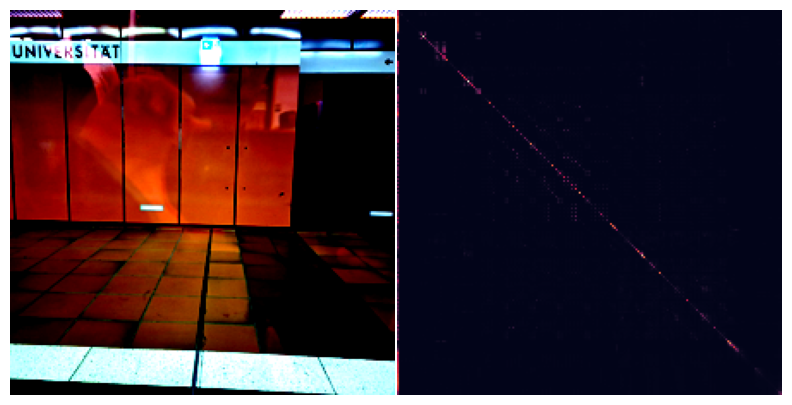

In [ ]:
fig = plt.figure(figsize=[10, 5], frameon=False)
ax = fig.add_subplot(1, 2, 1)
ax.axis("off")
ax.imshow(image.permute(1, 2, 0))
ax = fig.add_subplot(1, 2, 2)
ax.axis("off")
ax.imshow(image_attentions[0][0][0])  # check why this reshape
fig.subplots_adjust(hspace=0, wspace=0)